In [1]:
# Import essential libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import pickle
from collections import Counter, defaultdict

import scanpy as sc  # For single-cell RNA-seq data
import anndata  # Annotated data matrix
import bbknn  # Batch-balanced KNN

# Seaborn and Matplotlib for visualization
import seaborn as sns
from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import matplotlib.patches as mpatches

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/

### 2.1 Load and inspect data

In [2]:
with open('gene_dict.pkl', 'rb') as f:
    gene_dict = pickle.load(f)

In [3]:
with open('process_dict.pkl', 'rb') as f:
    process_dict = pickle.load(f)

In [4]:
# Load preprocessed datasets for three experiments
exp100=sc.read('SEC-Seq_Data/exp100.h5',gex_only=False)
exp105=sc.read('SEC-Seq_Data/exp105.h5',gex_only=False)
exp106=sc.read('SEC-Seq_Data/exp106.h5',gex_only=False)

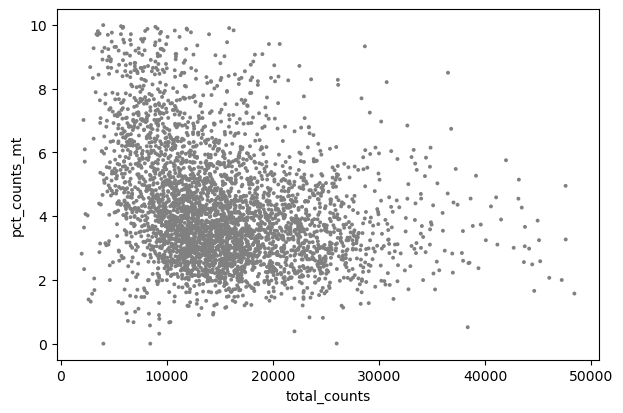

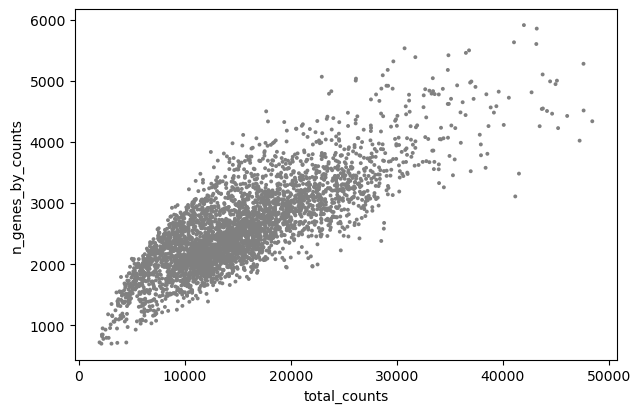

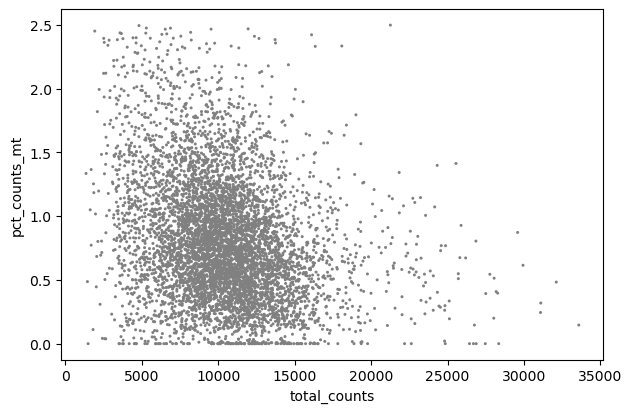

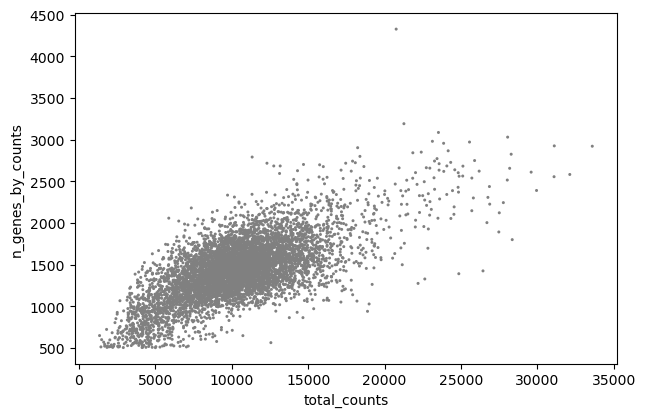

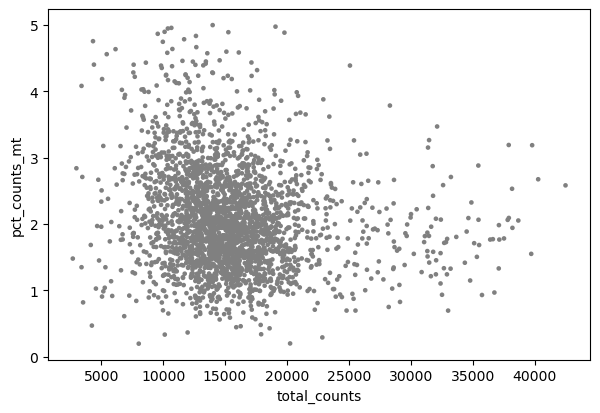

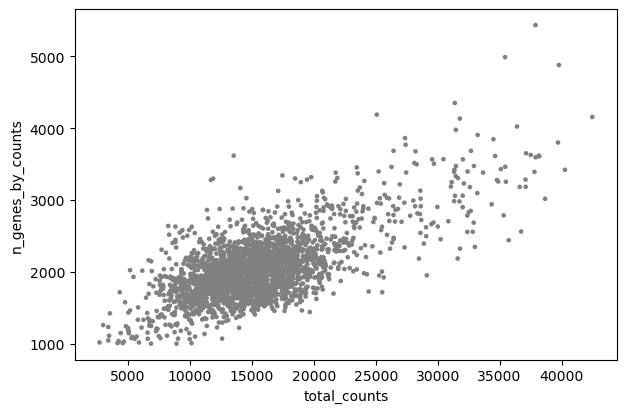

In [5]:
# Visualize QC metrics through scatter plots for each experiment
sc.pl.scatter(exp100, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(exp100, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(exp105, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(exp105, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(exp106, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(exp106, x='total_counts', y='n_genes_by_counts')

In [6]:
# Concatenate the three datasets into one combined dataset
data = exp100.concatenate(exp105, exp106, batch_key='sample')

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [7]:
# Save the concatenated dataset
data.write('SEC-Seq_Data/3data_raw.h5')

In [8]:
data1=data.copy() 

In [9]:
# Subset data based on the sample ID
d0=data1[data1.obs['sample']=='0']
d1=data1[data1.obs['sample']=='1']
d2=data1[data1.obs['sample']=='2']

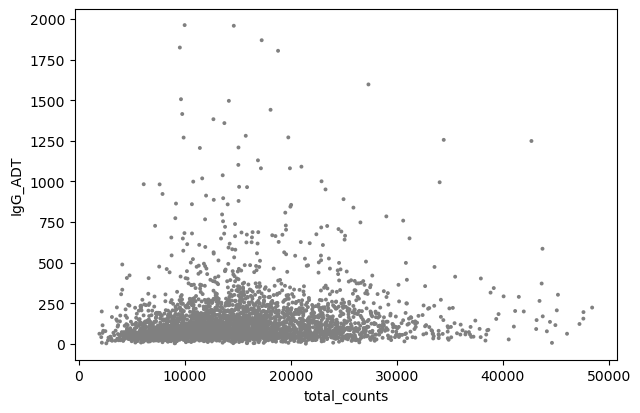

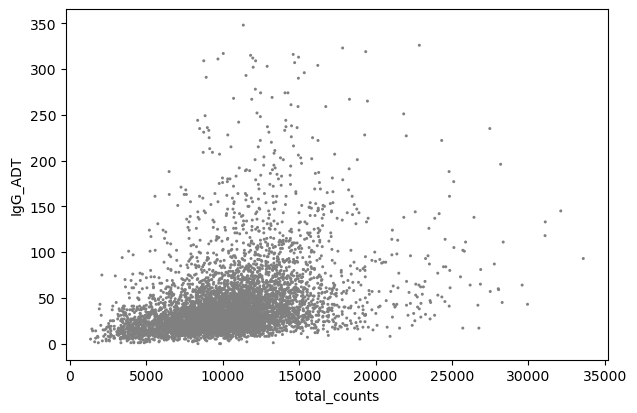

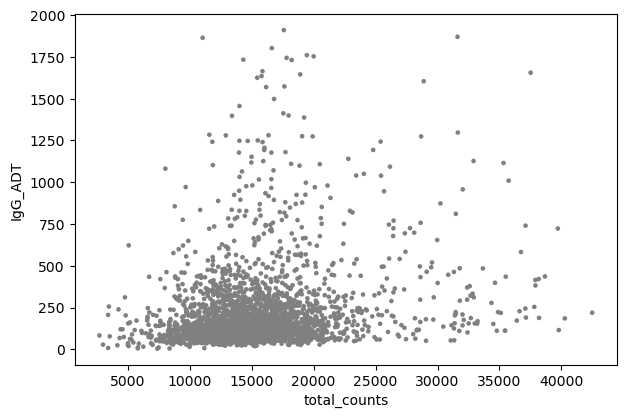

In [10]:
# Generate scatter plots for the three sample to show the relationship between total RNA counts and IgG_ADT
sc.pl.scatter(d0, x='total_counts', y='IgG_ADT')
sc.pl.scatter(d1, x='total_counts', y='IgG_ADT')
sc.pl.scatter(d2, x='total_counts', y='IgG_ADT')

#### QC Check

**n_genes_by_counts:** This metric represents the number of genes detected in each cell, based on counts. A very low number might indicate a low-quality cell or a cell with very low RNA content, while an extremely high number could suggest contamination or multiplets (more than one cell captured as a single cell).

**total_counts:** This is the total number of transcript counts detected in each cell. It reflects the overall sequencing depth or RNA content of each cell. Similar to n_genes_by_counts, extremely low or high values could indicate potential issues with cell quality or sequencing.

**pct_counts_mt:** This metric shows the percentage of counts that come from mitochondrial genes (MT- genes). A high percentage of mitochondrial gene expression is often used as an indicator of cell stress or cell death, as damaged cells may have compromised membrane integrity leading to the loss of cytoplasmic mRNA and relatively higher mitochondrial mRNA content.

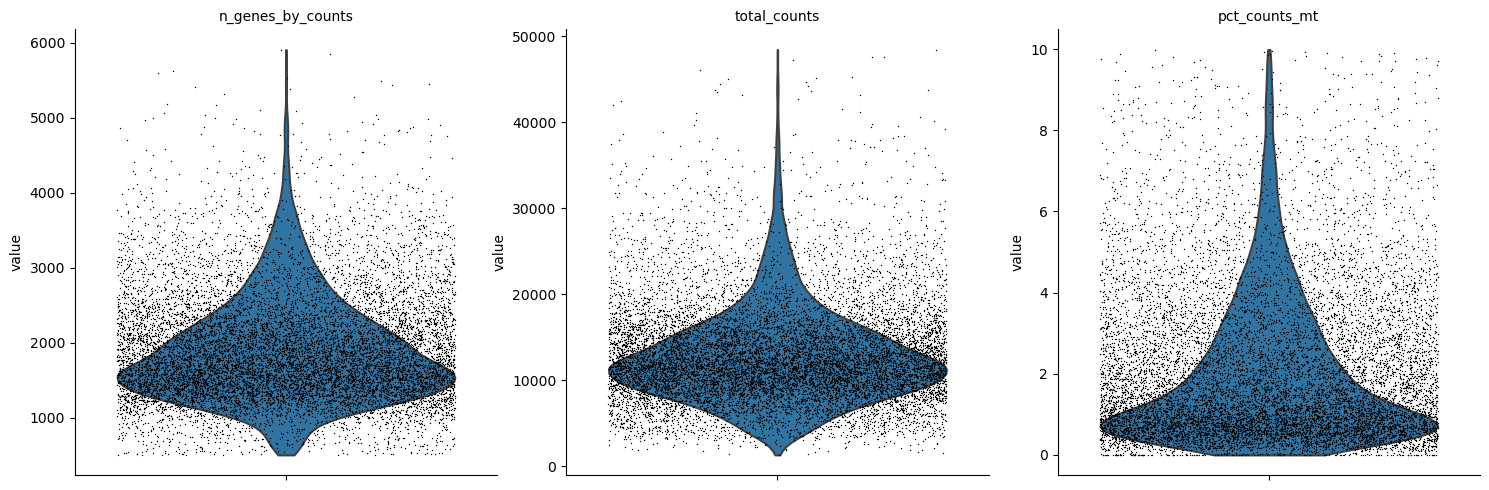

In [11]:
# Create violin plots for key quality control metrics ('n_genes_by_counts', 'total_counts', 'pct_counts_mt') across all samples
sc.pl.violin(data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


In [12]:
# Extract only the gene expression data from the full dataset and store it in a new variable 'rna'
rna=data[:, data.var["feature_types"] == "Gene Expression"].copy()

In [13]:
# Extract only the antibody capture data from the full dataset and store it in a new variable 'adt'
adt=data[:, data.var["feature_types"] == "Antibody Capture"].copy()

In [49]:
# They only have antibody capture for IgG
# normalization of adt # read the method section of Sec-Seq paper
# correlate values on adt to sec pathway genes in our recon

AnnData object with n_obs × n_vars = 12892 × 1
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2'
    layers: 'counts'

### 2.2 Data Normalization
This step is essential to ensure that comparisons of expression levels across cells are meaningful and not skewed by differences in sequencing depth or cell capture efficiency.

The function **sc.pp.normalize_total** calculates a scaling factor for each cell based on its total counts. This factor is determined by the ratio of the total counts in a cell to the median of the total counts across all cells.

Each gene's count in a cell is then scaled by the cell's scaling factor, adjusting the total expression counts across cells to be the same.

In [14]:
# Normalize the gene expression data so that the total counts for each cell sum to a constant value
sc.pp.normalize_total(rna)
# Apply logarithmic scaling to the normalized data
sc.pp.log1p(rna)

In [15]:
# Perform Principal Component Analysis (PCA) on the gene expression data for dimensionality reduction
sc.pp.pca(rna)
# Perform Batch Balanced K-Nearest Neighbors (BBKNN) to correct for batch effects in the data
sc.external.pp.bbknn(rna, batch_key='sample')

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


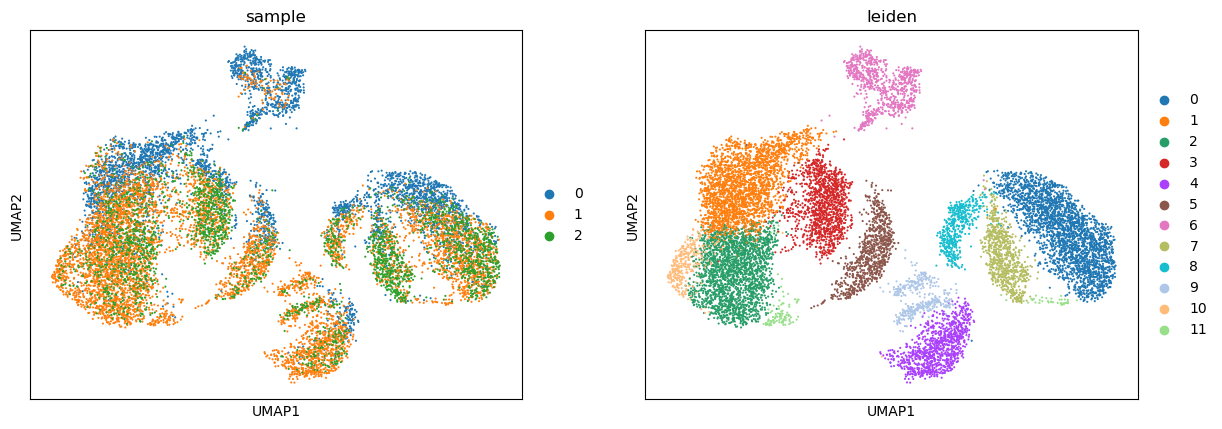

In [16]:
# Apply UMAP (Uniform Manifold Approximation and Projection) for data visualization
sc.tl.umap(rna)
# Cluster the cells using the Leiden algorithm
np.random.seed(0)
sc.tl.leiden(rna,resolution = 0.7,random_state=0)
# Visualize the UMAP plot, colored by sample origin and Leiden cluster assignments
sc.pl.umap(rna, color=['sample','leiden'])

### 2.2 Evaluate IG production per cluster

In [17]:
# Define categories based on Ig counts and store them as subsets of the main 'rna' AnnData object
M=rna[(rna.obs_vector('IGHM')> 4) & (rna.obs_vector('IGHA1') < 4.5)& (rna.obs_vector('IGHG1') < 4.5)]
A=rna[(rna.obs_vector('IGHA1') > 4.5)&(rna.obs_vector('IGHM')<4.6)&(rna.obs_vector('IGHG1')<3) ]
G1=rna[(rna.obs_vector('IGHG1') > 3)&(rna.obs_vector('IGHG2')<4)]
G3=rna[(rna.obs_vector('IGHG1') < 3)&(rna.obs_vector('IGHG3')>3.5)]
G2=rna[(rna.obs_vector('IGHG2') > 3.2)&(rna.obs_vector('IGHG3') <4.3)]
G4=rna[(rna.obs_vector('IGHG4') > 4)&(rna.obs_vector('IGHG3') <3.5)]

In [18]:
# Define subsets of the main 'rna' AnnData object based on IGKC and IGLC expression levels
K=rna[(rna.obs_vector('IGKC')> 6.5) & (rna.obs_vector('IGLC1') < 6)& (rna.obs_vector('IGLC2') < 6)& (rna.obs_vector('IGLC3') < 6)]
L=rna[(rna.obs_vector('IGKC')< 6.5) & ((rna.obs_vector('IGLC1') > 6)|(rna.obs_vector('IGLC2') > 6)|(rna.obs_vector('IGLC3') > 6)|(rna.obs_vector('IGLC5') > 0.25)|(rna.obs_vector('IGLC6') > 0.25)|(rna.obs_vector('IGLC7') > 6))]

In [19]:
# Initialize new columns 'Ig', 'IgL', and 'IgH' in the 'obs' DataFrame of the 'rna' object
rna.obs['Ig']='x'
rna.obs['IgL']='x'
rna.obs['IgH']='x'

In [20]:
# Assign values to 'Ig', 'IgL', and 'IgH' columns based on cell indices in subsets M, A, K, L, G1, G2, G3, and G4
m_i=M.obs.index
a_i=A.obs.index
kap_i=K.obs.index
lam_i=L.obs.index
g1_i=G1.obs.index
g2_i=G2.obs.index
g3_i=G3.obs.index
g4_i=G4.obs.index


rna.obs.loc[m_i,'Ig'] ='M'
rna.obs.loc[a_i,'Ig'] ='A'
rna.obs.loc[g1_i,'Ig'] ='G'
rna.obs.loc[g2_i,'Ig'] = 'G'
rna.obs.loc[g3_i,'Ig'] = 'G'
rna.obs.loc[g4_i,'Ig'] = 'G'


rna.obs.loc[kap_i, 'IgL'] = 'kappa'
rna.obs.loc[lam_i, 'IgL'] = 'lambda'

rna.obs.loc[m_i, 'IgH'] = 'M'
rna.obs.loc[a_i, 'IgH'] = 'A'
rna.obs.loc[g1_i, 'IgH'] = 'G1'
rna.obs.loc[g2_i, 'IgH'] = 'G2'
rna.obs.loc[g3_i, 'IgH'] = 'G3'
rna.obs.loc[g4_i, 'IgH'] = 'G4'

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots

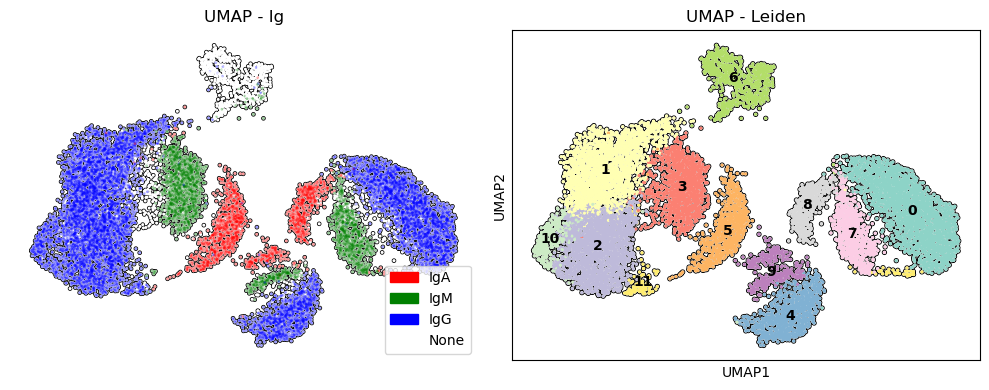

In [21]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# First subplot for UMAP visualization colored by the 'Ig' column values
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(rna, color=["Ig"], size=15,
               palette={'A':'red','M':'green','G':'blue','x':'white'}, alpha=0.4,
               add_outline=True, frameon=False, legend_loc='None', show=False, ax=axes[0])
    axes[0].set_title('UMAP - Ig')

# Second subplot for UMAP plot colored by Leiden cluster
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(rna, color=["leiden"], size=20, alpha=1, legend_loc="on data",
               add_outline=True, palette='Set3', show=False, ax=axes[1])
    axes[1].set_title('UMAP - Leiden')

# Creating a custom legend for the first subplot
legend_elements = [mpatches.Patch(color='red', label='IgA'),
                   mpatches.Patch(color='green', label='IgM'),
                   mpatches.Patch(color='blue', label='IgG'),
                   mpatches.Patch(color='white', label='None')]
axes[0].legend(handles=legend_elements, loc='lower right')

# Adjust the layout
plt.tight_layout()

# Save the figure
plt.savefig('Plots/umap_leiden_ig_rna.jpg', dpi=300)

In [22]:
rna_prod = rna[rna.obs.leiden!='6']

### 2.3 Re-define clusters after the elimination of Cluster 6

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/tools/_umap.py:165: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


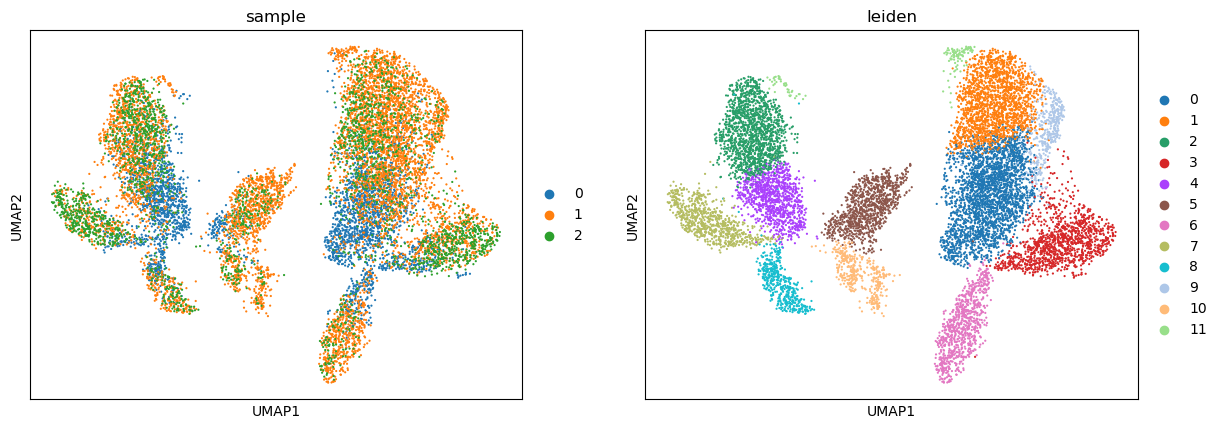

In [23]:
# Apply UMAP (Uniform Manifold Approximation and Projection) for data visualization
sc.tl.umap(rna_prod)
# Cluster the cells using the Leiden algorithm
np.random.seed(0)
sc.tl.leiden(rna_prod,resolution = 0.7,random_state=0)
# Visualize the UMAP plot, colored by sample origin and Leiden cluster assignments
sc.pl.umap(rna_prod, color=['sample','leiden'])

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots

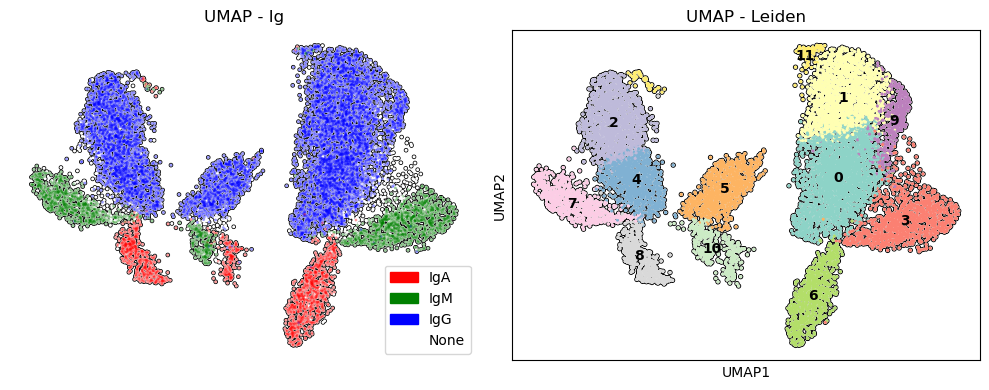

In [24]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# First subplot for UMAP visualization colored by the 'Ig' column values
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(rna_prod, color=["Ig"], size=15,
               palette={'A':'red','M':'green','G':'blue','x':'white'}, alpha=0.4,
               add_outline=True, frameon=False, legend_loc='None', show=False, ax=axes[0])
    axes[0].set_title('UMAP - Ig')

# Second subplot for UMAP plot colored by Leiden cluster
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(rna_prod, color=["leiden"], size=20, alpha=1, legend_loc="on data",
               add_outline=True, palette='Set3', show=False, ax=axes[1])
    axes[1].set_title('UMAP - Leiden')

# Creating a custom legend for the first subplot
legend_elements = [mpatches.Patch(color='red', label='IgA'),
                   mpatches.Patch(color='green', label='IgM'),
                   mpatches.Patch(color='blue', label='IgG'),
                   mpatches.Patch(color='white', label='None')]
axes[0].legend(handles=legend_elements, loc='lower right')

# Adjust the layout
plt.tight_layout()

# Save the figure
plt.savefig('Plots/umap_leiden_ig_rna_prod.jpg', dpi=300)

### 2.2 Extract differencially expressed genes in Leiden clusters

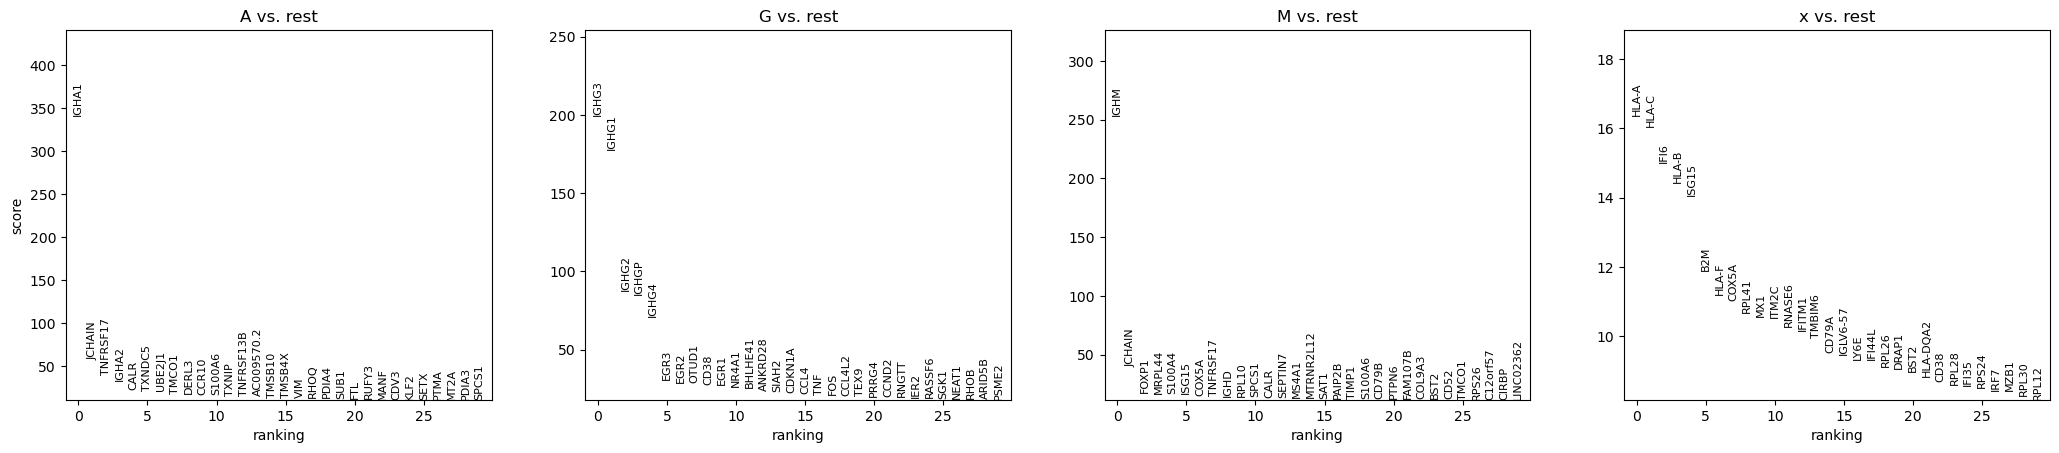

In [25]:
# Rank genes that are differentially expressed between Leiden clusters using the t-test method
rna_t=sc.tl.rank_genes_groups(rna_prod, 'Ig', method='t-test')

# Plot the top 30 differentially expressed genes for each cluster (filtered by p-value)
sc.pl.rank_genes_groups(rna_prod, n_genes=30, sharey=False)

In [26]:
# Initialize a set to store all unique gene names
all_genes = set()

# Populate the set with all unique gene names across all clusters
for cluster in rna_prod.uns['rank_genes_groups']['names'].dtype.names:
    gene_names = np.array(rna_prod.uns['rank_genes_groups']['names'][cluster])
    all_genes.update(gene_names)

# Convert the set to a list and sort it
all_genes = sorted(list(all_genes))

# Initialize a DataFrame with genes as rows
unified_df = pd.DataFrame(index=all_genes)

# Iterate over each cluster to populate the DataFrame
for cluster in rna_prod.uns['rank_genes_groups']['names'].dtype.names:
    gene_names = np.array(rna_prod.uns['rank_genes_groups']['names'][cluster])
    pvals = np.array(rna_prod.uns['rank_genes_groups']['pvals'][cluster])
    logfoldchanges = np.array(rna_prod.uns['rank_genes_groups']['logfoldchanges'][cluster])

    # Create temporary DataFrame for the cluster
    cluster_df = pd.DataFrame({
        f'p-value_{cluster}': pvals,
        f'LogFoldChange_{cluster}': logfoldchanges
    }, index=gene_names)

    # Join with the main DataFrame
    unified_df = unified_df.join(cluster_df, how='left')

# Replace NaN values
unified_df.fillna(0, inplace=True)

# Add columns for subcellular localization and processes
unified_df['Subcellular_Localization'] = [', '.join(gene_dict.get(gene, {}).get('subcellular_localization', [])) for gene in unified_df.index]
unified_df['Processes'] = [', '.join(gene_dict.get(gene, {}).get('processes', [])) for gene in unified_df.index]

# Save the unified DataFrame to an Excel file
filename = 'Output/unified_cluster_data.xlsx'
unified_df.to_excel(filename)
print(f"Saved unified data to {filename}")

Saved unified data to Output/unified_cluster_data.xlsx


### 2.3 Identify secretory pathway genes in Leiden clusters

In [38]:
# Access the structured array of results
results = rna_prod.uns['rank_genes_groups']

# Access the names of the genes and p-values, which are stored under 'names' and 'pvals' respectively
gene_names = results['names']
pvals = results['pvals']
logfoldchanges = results['logfoldchanges']

# Convert to DataFrames for easier manipulation
df_gene_names = pd.DataFrame(gene_names)
df_pvals = pd.DataFrame(pvals)
df_logfoldchanges = pd.DataFrame(logfoldchanges)

# Create a dictionary to store the filtered genes for each cluster
filtered_genes_dict = {}

for cluster in rna_prod.obs['Ig'].cat.categories:  # 13 clusters
    cluster_str = str(cluster)
    
    # Filter genes based on p-value < 0.05 and log fold change > 1.5
    mask = (df_pvals[cluster_str] < 0.05)# & (df_logfoldchanges[cluster_str] > 1)
    
    # Get the names of the genes that pass the filter
    filtered_genes = set(df_gene_names.loc[mask, cluster_str])
    
    # Store the filtered genes in the dictionary
    filtered_genes_dict[cluster] = filtered_genes

In [39]:
# Create a dictionary to store the intersections along with attributes
intersect_dict = {}

# Loop through each cluster and filter the secretory pathway genes from the "gene_dict"
for cluster in rna_prod.obs['Ig'].cat.categories:
    intersecting_genes = set(gene_dict.keys()).intersection(filtered_genes_dict[cluster])
    
    # Create a nested dictionary for each cluster
    nested_dict = {}
    
    # Populate the nested dictionary with attributes from gene_dict ('processes', 'subcellular_localization', 'complex')
    for gene in intersecting_genes:
        nested_dict[gene] = gene_dict.get(gene, {})
    
    # Update intersect_dict with the nested dictionary
    intersect_dict[cluster] = nested_dict

In [40]:
# Create new dictionary with the parent categories as subkeys and the amount of genes as items
categorized_intersect_dict = {}

# Loop through each cluster in intersect_dict
for cluster, genes in intersect_dict.items():
    categorized_intersect_dict[cluster] = {}
    
    # Initialize counters for each category
    category_counters = {
        'Translocation': 0,
        'Protein conformation': 0,
        'Post-translational modifications': 0,
        'Proteostasis': 0,
        'Vesicle trafficking': 0
    }
    
    # Loop through each gene in the cluster
    for gene, attributes in genes.items():
        process_counter = Counter()
        
        # Loop through each process for the gene
        for process in attributes['processes']:
            
            # Loop through each category in process_dict
            for category, sub_processes in process_dict.items():
                
                # Check if the process is in this category
                for sub_process_dict in sub_processes:
                    if process == sub_process_dict.get('Subsystem') or \
                       process == sub_process_dict.get('Process') or \
                       process == sub_process_dict.get('Subprocess'):
                        process_counter[category] += 1
        
        # Determine the category where the majority of processes for this gene are allocated
        if process_counter:  # Check if process_counter is not empty
            most_common_category, _ = process_counter.most_common(1)[0]
            
            # Add the gene to this category in the categorized dictionary
            if most_common_category not in categorized_intersect_dict[cluster]:
                categorized_intersect_dict[cluster][most_common_category] = []
            categorized_intersect_dict[cluster][most_common_category].append(gene)
        else:
            # Handle genes with no processes
            if 'No Category' not in categorized_intersect_dict[cluster]:
                categorized_intersect_dict[cluster]['No Category'] = []
            categorized_intersect_dict[cluster]['No Category'].append(gene)

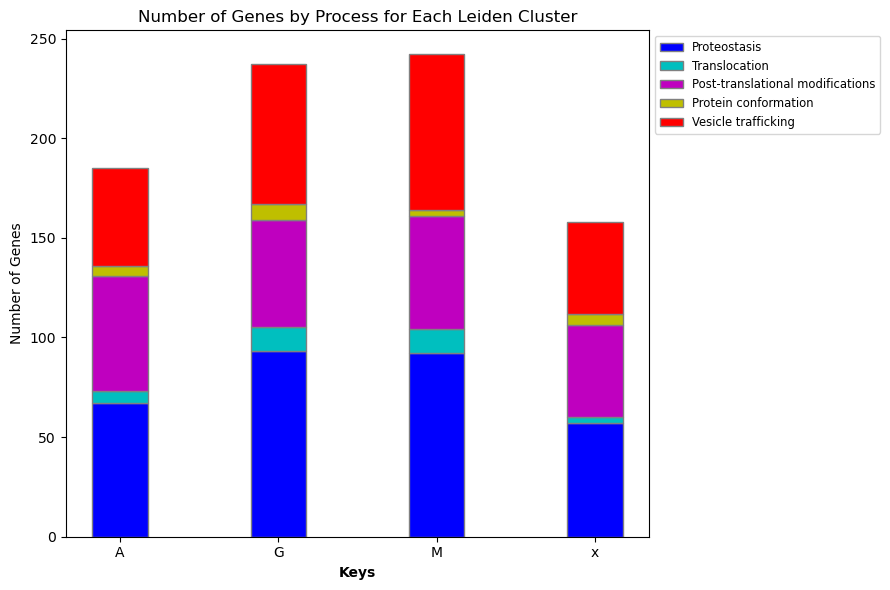

In [41]:
## --- Plot ----#

labels = list(categorized_intersect_dict.keys())
proteostasis = []
translocation = []
post_trans_mod = []
protein_conf = []
vesicle_traffic = []

# Populate the lists with the number of genes for each subkey
for key in labels:
    proteostasis.append(len(categorized_intersect_dict[key].get('Proteostasis', [])))
    translocation.append(len(categorized_intersect_dict[key].get('Translocation', [])))
    post_trans_mod.append(len(categorized_intersect_dict[key].get('Post-translational modifications', [])))
    protein_conf.append(len(categorized_intersect_dict[key].get('Protein conformation', [])))
    vesicle_traffic.append(len(categorized_intersect_dict[key].get('Vesicle trafficking', [])))

# Define the bar width
barWidth = 0.35

# Set position of bar on X axis
r1 = np.arange(len(labels))

# Make the plot
plt.figure(figsize=(12, 6))
plt.bar(r1, proteostasis, color='b', edgecolor='grey', width=barWidth, label='Proteostasis')
plt.bar(r1, translocation, color='c', edgecolor='grey', width=barWidth, bottom=proteostasis, label='Translocation')
plt.bar(r1, post_trans_mod, color='m', edgecolor='grey', width=barWidth, bottom=[i+j for i,j in zip(proteostasis, translocation)], label='Post-translational modifications')
plt.bar(r1, protein_conf, color='y', edgecolor='grey', width=barWidth, bottom=[i+j+k for i,j,k in zip(proteostasis, translocation, post_trans_mod)], label='Protein conformation')
plt.bar(r1, vesicle_traffic, color='r', edgecolor='grey', width=barWidth, bottom=[i+j+k+l for i,j,k,l in zip(proteostasis, translocation, post_trans_mod, protein_conf)], label='Vesicle trafficking')

# Add labels
plt.xlabel('Keys', fontweight='bold')
plt.ylabel('Number of Genes')
plt.xticks([r for r in range(len(labels))], labels)
plt.title('Number of Genes by Process for Each Leiden Cluster')

# Adjust the legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.75, 1])

# Show plot
plt.savefig('Plots/number_of_genes_by_process_each_leiden.jpg', dpi=300)
plt.show()

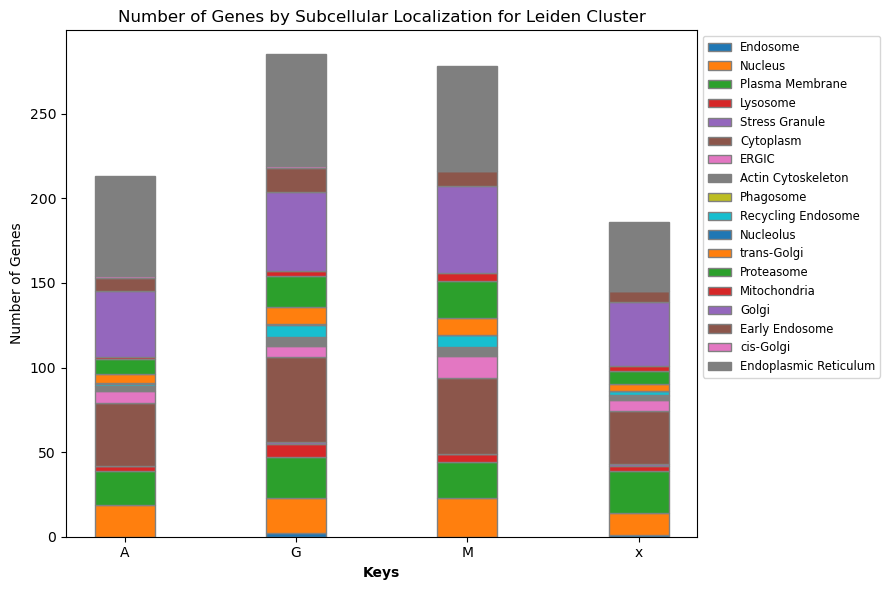

In [42]:
labels = list(intersect_dict.keys())
localization_counts = defaultdict(list)

# Populate the dictionary with the number of genes for each subcellular localization
for key in labels:
    local_count = defaultdict(int)
    for gene, attributes in intersect_dict[key].items():
        for local in attributes.get('subcellular_localization', []):
            local_count[local] += 1
    localization_counts[key] = local_count

# Define the bar width
barWidth = 0.35

# Set position of bar on X axis
r1 = np.arange(len(labels))

# Initialize bottom for stacked bar
bottoms = np.zeros(len(labels))

# Make the plot
plt.figure(figsize=(12, 6))
for local in set(local for d in localization_counts.values() for local in d.keys()):
    heights = [localization_counts[key].get(local, 0) for key in labels]
    plt.bar(r1, heights, edgecolor='grey', width=barWidth, bottom=bottoms, label=local)
    bottoms += np.array(heights)

# Add labels
plt.xlabel('Keys', fontweight='bold')
plt.ylabel('Number of Genes')
plt.xticks([r for r in range(len(labels))], labels)
plt.title('Number of Genes by Subcellular Localization for Leiden Cluster')

# Adjust the legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.75, 1])

# Show and save plot
plt.savefig('Plots/number_of_genes_subcellular_localization_each_leiden.jpg', dpi=300)
plt.show()

### 2.4 Enrichment Analysis

In [43]:
intersect_dict

{'A': {'SELENOS': {'processes': ['ERAD'],
   'subcellular_localization': ['Endoplasmic Reticulum'],
   'system': ['Proteostasis'],
   'subsystem': ['ERAD'],
   'process': [],
   'complex': ['DERL1-VCP-VIMP complex',
    'VCP-VIMP-DERL2 complex',
    'VCP-VIMP-DERL1-DERL2-HRD1-SEL1L complex',
    'Membrane protein complex (DERL1, NPLOC4, UFD1L, VCP, VIMP)',
    'SELK multiprotein complex']},
  'TBC1D2B': {'processes': ['Endocytosis'],
   'subcellular_localization': ['Cytoplasm'],
   'system': ['Vesicle trafficking'],
   'subsystem': ['Post-Golgi'],
   'process': ['Endocytosis'],
   'complex': None},
  'DNAJC3': {'processes': ['PERK pathway',
    'Protein folding',
    'Apoptosis',
    'Phosphorylation',
    'Co-translational translocation'],
   'subcellular_localization': ['Endoplasmic Reticulum'],
   'system': ['Proteostasis',
    'Protein conformation',
    'Translocation',
    'Post-translational modifications'],
   'subsystem': ['Apoptosis',
    'ER stress response/UPR',
    'Phosph

In [44]:
from utils import identify_enriched_processes

In [45]:
enrichment_df = identify_enriched_processes(intersect_dict, gene_dict, process_key='complex')
enrichment_df

,Cluster,Process,Count,Total_Count,Normalized_Count
0,A,DERL1-VCP-VIMP complex,2,3,0.666667
1,A,VCP-VIMP-DERL2 complex,2,3,0.666667
2,A,VCP-VIMP-DERL1-DERL2-HRD1-SEL1L complex,4,6,0.666667
3,A,"Membrane protein complex (DERL1, NPLOC4, UFD1L...",2,5,0.400000
4,A,SELK multiprotein complex,7,9,0.777778
...,...,...,...,...,...
990,x,MAK-ACTR-AR complex,1,2,0.500000
991,x,Arp2/3 protein complex,1,7,0.142857
992,x,HEXA-HEXB complex,1,2,0.500000
993,x,ECT2-KIF23-RACGAP1 complex,1,1,1.000000


In [46]:
# Pivot the DataFrame to create a suitable format for a heatmap
heatmap_data = enrichment_df.pivot("Process", "Cluster", "Normalized_Count")

# Fill NaN values with 0 to indicate no enrichment
heatmap_data = heatmap_data.fillna(0)

# Ensure the cluster columns are sorted numerically
heatmap_data = heatmap_data.sort_index(axis=1, key=lambda x: x.astype(str))

/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_3643/638229054.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = enrichment_df.pivot("Process", "Cluster", "Normalized_Count")


In [47]:
# Normalize row-wise
heatmap_data_normalized_row = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

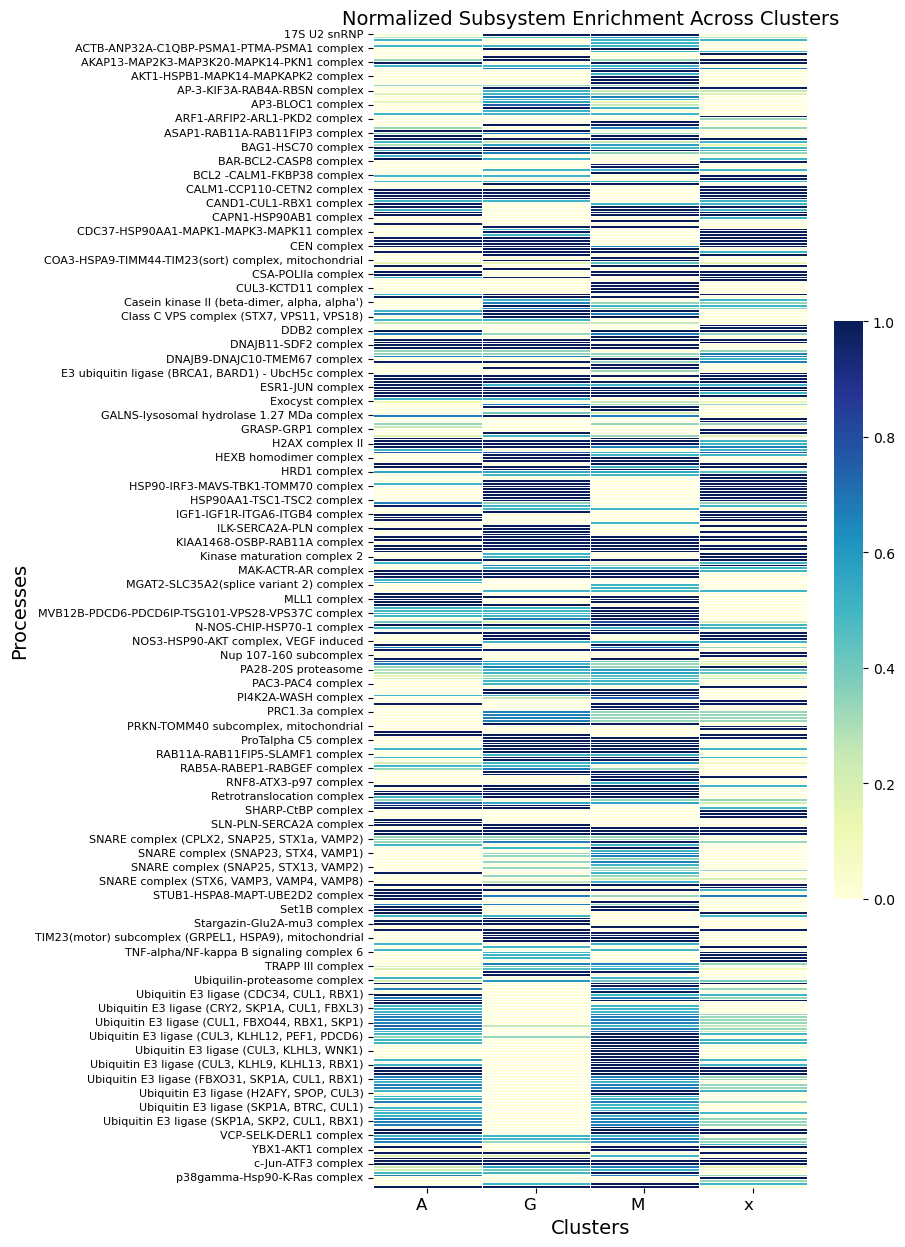

In [48]:
plt.figure(figsize=(7, 15))

# Adjusting the heatmap creation
ax = sns.heatmap(heatmap_data, annot=False, fmt=".0f", cmap="YlGnBu", linewidths=.5,
                 cbar_kws={'shrink': 0.5})  # Adjust 'shrink' to control the legend size

# Increase the size of the labels
plt.xticks(rotation=0, ha="right", fontsize=12)  # Adjust fontsize as needed
plt.yticks(rotation=0, fontsize=8)
plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Processes', fontsize=14)

# Set larger title with increased font size
plt.title("Normalized Subsystem Enrichment Across Clusters", fontsize=14)

plt.savefig('Plots/complex_enrichment_across_clusters.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Initialize an empty set to store unique gene names
unique_genes = set()

# Loop through the nested dictionary to extract gene names
for cluster, genes in intersect_dict.items():
    for gene in genes.keys():
        unique_genes.add(gene)

# Convert the set to a list
unique_gene_list = list(unique_genes)

In [ ]:
# Initialize an empty dictionary to temporarily store the genes for each process
temp_dict = {}

# Iterate through each cluster
for cluster, processes in categorized_intersect_dict.items():
    # Iterate through each process in the cluster
    for process, genes in processes.items():
        # If the process is not already in temp_dict, add it
        if process not in temp_dict:
            temp_dict[process] = []
        
        # Add the genes to the list for that process, eliminating duplicates
        temp_dict[process] = list(set(temp_dict[process] + genes))

# Create separate lists for each process
for process, genes in temp_dict.items():
    exec(f"{process.replace(' ', '_').replace('-', '_')} = {genes}")

In [ ]:
#my_gene_list = list(gene_dict.keys())
my_gene_list = list(temp_dict)

In [ ]:
values_list = []
for key in temp_dict:
    values_list.extend(temp_dict[key])

In [ ]:
# Score the cells based on your gene list
sc.tl.score_genes(rna_prod, 
                  gene_list=values_list, 
                  ctrl_size=100, 
                  gene_pool=None, 
                  n_bins=2, 
                  score_name='sec_gene_score', 
                  random_state=0, 
                  copy=False, 
                  use_raw=None)

In [ ]:
# Plot the UMAP with the gene score as color
sc.pl.umap(rna_prod, color=['sec_gene_score'], cmap='viridis')

In [ ]:
# Create a new figure and axis # agregaate score genes with the same processes
fig, ax = plt.subplots()

# Plot the UMAP coordinates without color
sc.pl.umap(rna, color=None, ax=ax, show=False, size=15, frameon=False)

# List of genes to color
genes_to_color = ['DERL3', 'UBE2J1', 'HSPA5', 'CALR', 'PDIA4', 'HSP90B1', 'SELENOS', 'PDIA3', 'SPCS3', 'SPCS1']

# Get UMAP coordinates
umap_coords = rna.obsm['X_umap']

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 8))

# Loop through each gene and add a color layer
for gene in genes_to_color:
    expression_values = rna[:, gene].X.toarray().flatten() if hasattr(rna[:, gene].X, 'toarray') else rna[:, gene].X
    #normalized_values = (expression_values - np.min(expression_values)) / (np.max(expression_values) - np.min(expression_values))
    ax.scatter(umap_coords[:, 0], umap_coords[:, 1], c=expression_values, cmap='Purples', alpha=0.5, label=gene)

# Add legend and labels
ax.legend()
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

# Show the plot
plt.show()

In [ ]:
# Plot a UMAP visualization colored by expression levels of the gene 'MIF'
with rc_context({'figure.figsize': (8.4, 8)}):

#     ax = sc.pl.umap(rna, size=50, show=False)
    ax=sc.pl.umap(rna,color=['DERL3','UBE2J1','HSPA5','CALR','PDIA4','HSP90B1','SELENOS','PDIA3','SPCS3','SPCS1'], legend_loc='none',size=15,show=False, alpha=1,
                    add_outline=True,frameon=False, cmap='Purples',colorbar_loc=None,vmin=1.5,
                   )
    #ax.set_title('')   
plt.show()

In [ ]:
# Group data by 'sample' and 'leiden' cluster, then normalize within each group to create a stacked bar plot
d=rna.obs
dd=d.groupby('sample')['leiden'].value_counts(normalize=True).unstack('sample')
# al=d['leiden'].value_counts(normalize=True)
# dd['all']= al

labels = dd.columns
c0= dd.iloc[0]
c1 =  dd.iloc[1]
c2 = dd.iloc[2]
c3 = dd.iloc[3]
c4 = dd.iloc[4]
c5 = dd.iloc[5]
c6 = dd.iloc[6]
c7 = dd.iloc[7]
c8 = dd.iloc[8]
c9 = dd.iloc[9]
c10 = dd.iloc[10]

fig = plt.figure(figsize=(1,4))
ax = fig.add_subplot(111)
width = 0.55       # the width of the bars: can also be len(x) sequence

cmap=mpl.colormaps.get_cmap("Set3").colors
ax.bar(labels, c0, width,color=cmap[0],alpha=1)
ax.bar(labels, c1, width, bottom=c0,color=cmap[1],alpha=1,)
ax.bar(labels, c2, width, bottom=c0+c1,color=cmap[2],alpha=1,)
ax.bar(labels, c3, width, bottom=c0+c1+c2,color=cmap[3],alpha=1,)
ax.bar(labels, c4, width, bottom=c0+c1+c2+c3,color=cmap[4],alpha=1,)
ax.bar(labels, c5, width, bottom=c0+c1+c2+c3+c4,color=cmap[6],alpha=1,)
ax.bar(labels, c6, width, bottom=c0+c1+c2+c3+c4+c5,color=cmap[7],alpha=1,)
ax.bar(labels, c7, width, bottom=c0+c1+c2+c3+c4+c5+c6,color=cmap[8],alpha=1,)
ax.bar(labels, c8, width, bottom=c0+c1+c2+c3+c4+c5+c6+c7,color=cmap[9],alpha=1,)
ax.bar(labels, c9, width, bottom=c0+c1+c2+c3+c4+c5+c6+c7+c8,color=cmap[10],alpha=1,)
ax.bar(labels, c10, width, bottom=c0+c1+c2+c3+c4+c5+c6+c7+c8+c9,color=cmap[11],alpha=1,)



# plt.ylim(0,1.1)

# plt.savefig('gbar.pdf')
# plt.legend(loc='upper right')
plt.show()

dd

In [ ]:
#Generates a UMAP plot for 'rna' object, colored by Leiden cluster
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(rna, color=["leiden"], size=20,alpha=1,legend_loc="on data", 
               add_outline=True,palette='Set3', show=False)
#     sc.pl.umap(rna, color=['sample'], size=20,)
plt.savefig('leiden.pdf')

In [ ]:
# Define categories based on Ig counts and store them as subsets of the main 'rna' AnnData object
M=rna[(rna.obs_vector('IGHM')> 4) & (rna.obs_vector('IGHA1') < 4.5)& (rna.obs_vector('IGHG1') < 4.5)]
A=rna[(rna.obs_vector('IGHA1') > 4.5)&(rna.obs_vector('IGHM')<4.6)&(rna.obs_vector('IGHG1')<3) ]
G1=rna[(rna.obs_vector('IGHG1') > 3)&(rna.obs_vector('IGHG2')<4)]
G3=rna[(rna.obs_vector('IGHG1') < 3)&(rna.obs_vector('IGHG3')>3.5)]
G2=rna[(rna.obs_vector('IGHG2') > 3.2)&(rna.obs_vector('IGHG3') <4.3)]
G4=rna[(rna.obs_vector('IGHG4') > 4)&(rna.obs_vector('IGHG3') <3.5)]

In [ ]:
# Define subsets of the main 'rna' AnnData object based on IGKC and IGLC expression levels
K=rna[(rna.obs_vector('IGKC')> 6.5) & (rna.obs_vector('IGLC1') < 6)& (rna.obs_vector('IGLC2') < 6)& (rna.obs_vector('IGLC3') < 6)]
L=rna[(rna.obs_vector('IGKC')< 6.5) & ((rna.obs_vector('IGLC1') > 6)|(rna.obs_vector('IGLC2') > 6)|(rna.obs_vector('IGLC3') > 6)|(rna.obs_vector('IGLC5') > 0.25)|(rna.obs_vector('IGLC6') > 0.25)|(rna.obs_vector('IGLC7') > 6))]

In [ ]:
# Initialize new columns 'Ig', 'IgL', and 'IgH' in the 'obs' DataFrame of the 'rna' object
rna.obs['Ig']='x'
rna.obs['IgL']='x'
rna.obs['IgH']='x'

In [ ]:
# Assign values to 'Ig', 'IgL', and 'IgH' columns based on cell indices in subsets M, A, K, L, G1, G2, G3, and G4
m_i=M.obs.index
a_i=A.obs.index
kap_i=K.obs.index
lam_i=L.obs.index
g1_i=G1.obs.index
g2_i=G2.obs.index
g3_i=G3.obs.index
g4_i=G4.obs.index


rna.obs.loc[m_i,'Ig'] ='M'
rna.obs.loc[a_i,'Ig'] ='A'
rna.obs.loc[g1_i,'Ig'] ='G'
rna.obs.loc[g2_i,'Ig'] = 'G'
rna.obs.loc[g3_i,'Ig'] = 'G'
rna.obs.loc[g4_i,'Ig'] = 'G'


rna.obs.loc[kap_i, 'IgL'] = 'kappa'
rna.obs.loc[lam_i, 'IgL'] = 'lambda'

rna.obs.loc[m_i, 'IgH'] = 'M'
rna.obs.loc[a_i, 'IgH'] = 'A'
rna.obs.loc[g1_i, 'IgH'] = 'G1'
rna.obs.loc[g2_i, 'IgH'] = 'G2'
rna.obs.loc[g3_i, 'IgH'] = 'G3'
rna.obs.loc[g4_i, 'IgH'] = 'G4'

In [ ]:
# Plot a UMAP visualization colored by the 'Ig' column values
with rc_context({'figure.figsize': (4, 4)}):
    
    ax=sc.pl.umap(rna, color=["Ig"], size=15,
               palette={'A':'red','M':'green','G':'blue','x':'white'},alpha=0.4,add_outline=True,
              frameon=False,legend_loc='None', show=False)
    ax.set_title('')   
    

In [ ]:
# Create a scatter plot for the expression levels of IGHA1 and IGHM
G=rna[rna.obs.Ig=='G']
x='IGHM'
y='IGHA1'
fig=plt.figure(figsize=(4,4))
plt.scatter(rna.obs_vector(x),rna.obs_vector(y),color='k',s=2)
# plt.scatter(M.obs_vector(x),M.obs_vector(y),color='k',s=2)
# plt.scatter(A.obs_vector(x),A.obs_vector(y),color='grey',s=2)
# plt.scatter(G.obs_vector(x),G.obs_vector(y),color='mediumaquamarine',s=2)

plt.show()
# plt.axvline(x=4.5,linewidth=1, c='k')
# plt.axhline(y=4.35,linewidth=1, c='k')

In [ ]:
# Define subsets 'negA' and 'negM' based on very low expression levels of IGHA1 and IGHM
negA=rna[rna.obs_vector('IGHA1')<0.05]
negM=rna[rna.obs_vector('IGHM')<0.05]

In [ ]:
negM

In [ ]:
# Perform log-transformation on 'datar' and assign it to the raw attribute of the 'rna' object
datar=data[data.obs.index.isin(rna.obs.index)]

sc.pp.log1p(datar)
rna.raw = datar

In [ ]:
# Split data into two subsets based on Leiden cluster '6'
c6=rna[rna.obs.leiden=='6']
asc=rna[rna.obs.leiden!='6']

In [ ]:
# Plot a UMAP visualization colored by the 'Ig' column values
with rc_context({'figure.figsize': (4, 4)}):
    
    ax=sc.pl.umap(asc, color=["Ig"], size=15,
               palette={'A':'red','M':'green','G':'blue','x':'white'},alpha=0.4,add_outline=True,
              frameon=False,legend_loc='None', show=False)
    ax.set_title('')   
    

In [ ]:
# Plot histograms for 'IgG_ADT' expression in subsets of samples '0', '1', and '2'
fig = plt.figure(figsize=(8,12))

ax = sns.set(font_scale=1.3) 
ax = sns.set_style("white")
# sns.kdeplot( M.obs_vector('IgG_ADT'), #kde=False,
#    color = 'slategrey',shade=True)
ax1 = fig.add_subplot(311)
s0=rna[rna.obs['sample']=='0']
s0M=s0[s0.obs.Ig=='M']
s0A=s0[s0.obs.Ig=='A']
s0G=s0[s0.obs.Ig=='G']
ax1 = sns.distplot(s0M.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'k',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s0A.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'b',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s0G.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'red',bins=100,norm_hist=True
        )#,bins=int(30))
# sns.kdeplot( A.obs_vector('IgG_ADT'), #kde=False,
#              color = 'purple',shade=True)
ax1.set(xlabel=None)
ax1.set(ylabel=None)
# plt.xticks([])
# plt.yticks([])

# # plt.axvline(x=5,linewidth=1,c='purple' )
fig = plt.figure(figsize=(8,12))

ax = sns.set(font_scale=1.3) 
ax = sns.set_style("white")
# sns.kdeplot( M.obs_vector('IgG_ADT'), #kde=False,
#    color = 'slategrey',shade=True)
ax1 = fig.add_subplot(311)
s1=rna[rna.obs['sample']=='1']
s1M=s1[s1.obs.Ig=='M']
s1A=s1[s1.obs.Ig=='A']
s1G=s1[s1.obs.Ig=='G']
ax1 = sns.distplot(s1M.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'k',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s1A.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'b',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s1G.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'red',bins=100,norm_hist=True
        )#,bins=int(30))
# sns.kdeplot( A.obs_vector('IgG_ADT'), #kde=False,
#              color = 'purple',shade=True)
ax1.set(xlabel=None)
ax1.set(ylabel=None)
# plt.xticks([])
# plt.yticks([])

# # plt.axvline(x=5,linewidth=1,c='purple' )


fig = plt.figure(figsize=(8,12))

ax = sns.set(font_scale=1.3) 
ax = sns.set_style("white")
# sns.kdeplot( M.obs_vector('IgG_ADT'), #kde=False,
#    color = 'slategrey',shade=True)
ax1 = fig.add_subplot(311)
s2=rna[rna.obs['sample']=='2']
s2M=s2[s2.obs.Ig=='M']
s2A=s2[s2.obs.Ig=='A']
s2G=s2[s2.obs.Ig=='G']
ax1 = sns.distplot(s2M.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'k',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s2A.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'b',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s2G.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'red',bins=100,norm_hist=True
        )#,bins=int(30))
# sns.kdeplot( A.obs_vector('IgG_ADT'), #kde=False,
#              color = 'purple',shade=True)
ax1.set(xlabel=None)
ax1.set(ylabel=None)
# plt.xticks([])
# plt.yticks([])

# # plt.axvline(x=5,linewidth=1,c='purple' )


plt.show()